In [1]:
# from pymeasure.instruments.keithley import Keithley2450
import numpy as np
import pandas as pd
from time import sleep
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import pyvisa

## Connection

In [5]:
PLOTS_PATH = 'plots/'

In [2]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('USB0::0x05E6::0x2450::04505744::INSTR',
 'ASRL1::INSTR',
 'ASRL3::INSTR',
 'ASRL4::INSTR')

In [3]:
address = 'USB0::0x05E6::0x2450::04505744::INSTR'

In [11]:
inst = rm.open_resource(address)

In [5]:
# inst.write("loadscript CellTest")
# inst.write('function sweepconfig(range_v, min_v, max_v, num)')
# inst.write('reset()')
# inst.write('smu.measure.func = smu.FUNC_DC_CURRENT')
# inst.write('smu.source.func = smu.FUNC_DC_VOLTAGE')
# inst.write('smu.terminals = smu.TERMINALS_FRONT')
# inst.write('smu.measure.sense = smu.SENSE_4WIRE')
# inst.write('smu.measure.autorange = smu.ON')
# inst.write('smu.measure.nplc = 1')
# inst.write('smu.source.highc = smu.OFF')
# inst.write('smu.source.range = range_v')
# inst.write('smu.source.readback = smu.ON')
# inst.write('smu.source.ilimit.level = 1')
# inst.write('smu.source.sweeplinear("SolarCell", min_v, max_v, num, 0.1)')
# inst.write("end")
# inst.write('function triggerprocess()')
# inst.write('trigger.model.initiate()')
# inst.write('waitcomplete()')
# inst.write('printbuffer(1, defbuffer1.n, defbuffer1.sourcevalues, defbuffer1.readings)')
# inst.write("end")
# inst.write("endscript")
# inst.write("CellTest.save()") # Save the script, DiodeTest, into nonvolatile memory


17

In [6]:
inst.write("CellTest.delete()")

19

In [7]:
inst.write("CellTest()")

12

In [8]:
min_voltage = 0
max_voltage = 3
range_v = max(abs(min_voltage), abs(max_voltage))
num = 10

inst.timeout = 10000
inst.write("sweepconfig("
           +str(range_v)+', '
           +str(min_voltage)+', '
           +str(max_voltage)+', '
           +str(num)+")")
buffer = inst.query("triggerprocess()")

In [14]:
results = np.fromstring(buffer, dtype=float, sep=',').reshape(-1, 2)

In [15]:
df = pd.DataFrame(columns=['Voltage (V)',
                           'Current (A)'],
                          data=results)

In [16]:
df

,Voltage (V),Current (A)
0,-0.000229,1.687244e-11
1,0.333296,-2.332013e-11
2,0.666450,-1.302851e-11
3,0.999932,-3.855850e-11
4,1.333443,-5.137320e-11
5,1.666625,-1.227705e-10
6,1.999989,-9.506873e-11
7,2.333672,-6.565145e-11
8,2.666705,-8.591192e-11
9,3.000064,-1.552260e-10


In [2]:
sourcemeter = Keithley2450('USB0::0x05E6::0x2450::04505744::INSTR')

In [8]:
sourcemeter.beep(1000, 1)
# sourcemeter.triad(1000, 1)

## Sweep function

In [9]:
def sweep(data_points, min_voltage, max_voltage, timeout):
    sourcemeter.write("*RST")
    sourcemeter.write("SENS:FUNC 'CURR'")
    sourcemeter.write("SENS:CURR:RANG:AUTO ON")
    sourcemeter.write("SOUR:FUNC VOLT")
    sourcemeter.write("SOUR:VOLT:RANG {}"
                      .format(max(abs(min_voltage), 
                                  abs(max_voltage))))
    sourcemeter.write("SOUR:VOLT:ILIM 1")
    sourcemeter.write("SOUR:SWE:VOLT:LIN {}, {}, {}, {}"
                      .format(min_voltage, max_voltage,
                              data_points, timeout))
    sourcemeter.write(":INIT")
    sourcemeter.write("*WAI")
    
    for i in tqdm(range(data_points)):
        sleep(2 * timeout)
    
    sleep(1)
        
#     sourcemeter.shutdown()
#     return pd.DataFrame(columns=['Voltage (V)',
#                                  'Current (A)'],
#                         data=results)

In [4]:
samplename='TEST'
data_points = 10
max_voltage = 5
min_voltage = -5
timeout = 0.1

In [10]:
sweep(data_points, min_voltage, max_voltage, timeout)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.80it/s]


In [11]:
results = np.array(sourcemeter
                       .values("TRAC:DATA? 1, {}, 'defbuffer1', SOUR, READ"
                               .format(data_points))
                      ).reshape(-1, 2)

data = pd.DataFrame(columns=['Voltage (V)',
                             'Current (A)'],
                    data=results)

In [22]:
sourcemeter.shutdown()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [27]:
results = sourcemeter.values("TRAC:DATA? 1, {}, 'defbuffer1', SOUR, READ"
                               .format(data_points))

In [28]:
results

[-5.103202,
 -6.619493e-10,
 -3.889097,
 -9.898238e-12,
 -2.886328,
 1.190192e-09,
 -1.666461,
 -2.713453e-11,
 -0.6371131,
 -8.197485e-10,
 0.5552976,
 -1.157041e-11,
 1.564913,
 7.840849e-10,
 2.777991,
 1.226518e-10,
 3.799834,
 -4.167882e-11,
 4.929435,
 8.506653e-10]

In [297]:
# light = False
light = True

In [298]:
if light:
    uv = data
    uv.to_csv(samplename+'UV.csv', index=False)
    print('UV saved')
else:
    nouv = data
    nouv.to_csv(samplename+'NO UV.csv', index=False)
    print('No UV saved')

UV saved


Text(0.5, 1.0, 'I-V plot')

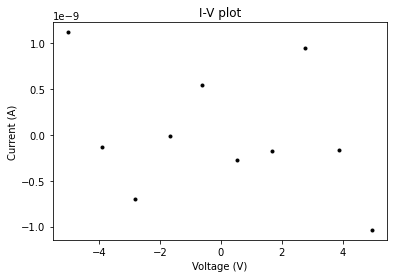

In [13]:
# data = pd.DataFrame(columns=['Voltage (V)', 'Current (A)'], data=results)
# data.to_csv('example.csv', index=False)
plt.errorbar(data['Voltage (V)'],
             data['Current (A)'],
#              yerr=voltage_stds, 
             fmt='.k')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('I-V plot')

## I-V Plot Function

In [108]:
def ivplot(df1, df2, samplename, scale):
#     xmargin = 0.1
    a_scale = {'nano': ['nA', 1e9],
               'micro': ['μA', 1e6],
               'mili': ['mA', 1e3]}
    
    fig, ax = plt.subplots()
    
    uv_current = df2['Current (A)']*a_scale[scale][1]
    no_uv_current = df1['Current (A)']*a_scale[scale][1]
    
#     ax.plot(df2['Voltage, V'], uv_current, label='UV ON')
#     ax.plot(df1['Voltage, V'], no_uv_current, label='UV OFF')
    ax.plot(df1['Voltage (V)'], no_uv_current, label='UV OFF')
    ax.plot(df2['Voltage (V)'], uv_current, label='UV ON')

    plt.xlim(round(df2['Voltage (V)'].min()), round(df2['Voltage (V)'].max()))
#     plt.xlim(0, 5)
    ymargin = ((df2['Voltage (V)'].max())/df2['Voltage (V)'].max() - 1)*uv_current.max()
    ymargin = round(ymargin, 2)
    plt.ylim(uv_current.min()-ymargin, uv_current.max()+ymargin)
#     plt.ylim(-10, 10)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

    plt.title('I-V Of Sample ' + samplename)
    plt.xlabel("Voltage, V")
    plt.ylabel('Current, ' + a_scale[scale][0])

    ax.grid(which='major',
            color = 'k')

    ax.minorticks_on()

    ax.grid(which='minor',
            color = 'gray',
            linestyle = ':')
    
    ax.tick_params(axis = 'both',
                   which = 'both',
                   direction = 'in')

    ax.legend()
    plt.savefig(PLOTS_PATH + 'I-V' + samplename + '.jpeg', dpi=400)

In [83]:
# uv = uv[(uv['Voltage (V)']<9) & (uv['Voltage (V)']>-9)]

In [84]:
# nouv = nouv[(nouv['Voltage (V)']<9) & (nouv['Voltage (V)']>-9)]

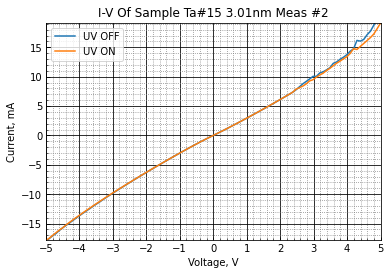

In [300]:
ivplot(nouv, uv, samplename=samplename, scale='mili')

In [51]:
# from io import BytesIO
# from pymeasure.instruments.keithley import Keithley2450
# from time import sleep
# import streamlit as st
# import numpy as np
# import pandas as pd
# import plotly.express as px


# @st.cache
# def convert_df(df):
#     # IMPORTANT: Cache the conversion to prevent computation on every rerun
#     return df.to_csv(index=False).encode('utf-8')


# @st.cache
# def to_excel(df):
#     output = BytesIO()
#     writer = pd.ExcelWriter(output, engine='xlsxwriter')
#     df.to_excel(writer, index=False, sheet_name='Sheet1')
#     workbook = writer.book
#     worksheet = writer.sheets['Sheet1']
#     format1 = workbook.add_format({'num_format': '0.00'})
#     worksheet.set_column('A:A', None, format1)
#     writer.save()
#     processed_data = output.getvalue()
#     return processed_data


TIMEOUT = 0.1
# Setting up instrument
# sourcemeter = Keithley2450('USB0::0x05E6::0x2450::04505744::INSTR')


# Function that sends sweep to instrument
def sweep(data_points, min_voltage, max_voltage, timeout):
    sourcemeter.write("*RST")
    sourcemeter.write("SENS:FUNC 'CURR'")
    sourcemeter.write("SENS:CURR:RANG:AUTO ON")
    sourcemeter.write("SOUR:FUNC VOLT")
    sourcemeter.write("SOUR:VOLT:RANG {}"
                      .format(max(abs(min_voltage),
                                  abs(max_voltage))))
    sourcemeter.write("SOUR:VOLT:ILIM 1")
    sourcemeter.write("SOUR:SWE:VOLT:LIN {}, {}, {}, {}"
                      .format(min_voltage, max_voltage,
                              data_points, timeout))
    sourcemeter.write(":INIT")
    sourcemeter.write("*WAI")


# UI & script body
# with st.sidebar.form(key="Params"):
#     sample_name = st.text_input("Plot Name", placeholder="New Plot")  # for example: 'Ta#15 3.01nm Meas #2'
#     data_points = st.number_input("Data points", min_value=3, max_value=1000, value=10, step=1)
#     min_voltage = st.number_input("Min Voltage (V)", min_value=-100.0, max_value=0.0, value=0.0, step=0.1)
#     max_voltage = st.number_input("Max Voltage (V)", min_value=0.0, max_value=100.0, value=3.0, step=0.1)
#     measure = st.form_submit_button("Measure I-V")

# progress_bar = st.sidebar.progress(0)
# status_text = st.sidebar.empty()

# if measure:
sweep(data_points, min_voltage, max_voltage, TIMEOUT)
for i in range(data_points):
    sleep(11 * TIMEOUT)
    percent = int(i / data_points * 97)
#     status_text.text("%i%% Complete" % percent)
#     progress_bar.progress(percent)

try:
    results = np.array(sourcemeter
                       .values("TRAC:DATA? 1, {}, 'defbuffer1', SOUR, READ"
                               .format(data_points))
                       ).reshape(-1, 2)
    df = pd.DataFrame(columns=['Voltage (V)',
                               'Current (A)'],
                      data=results)
except ValueError:
    sleep(5)
    results = np.array(sourcemeter
                       .values("TRAC:DATA? 1, {}, 'defbuffer1', SOUR, READ"
                               .format(data_points))
                       ).reshape(-1, 2)
    df = pd.DataFrame(columns=['Voltage (V)',
                               'Current (A)'],
                      data=results)
#     status_text.text("%i%% Complete" % 100)
#     progress_bar.empty()

    # Saves data
#     st.session_state['df'] = df

# if 'df' in st.session_state:
#     # status_text.text("%i%% Complete" % 100)
#     # progress_bar.empty()
#     filename = 'Untitled'
#     if sample_name != '':
#         filename = sample_name
#     df = st.session_state.df
#     fig = px.line(df, x='Voltage (V)', y='Current (A)', markers=True)
#     fig.update_layout(title_text=filename, title_x=0.5)
#     st.plotly_chart(fig, use_container_width=True)

#     csv = convert_df(df)
#     st.download_button(
#         label="Download data as CSV",
#         data=csv,
#         file_name=filename + '.csv',
#         mime='text/csv',
#     )

#     xlsx = to_excel(df)
#     st.download_button(
#         label="Download data as XLSX",
#         data=xlsx,
#         file_name=filename + '.xlsx'
#     )


# st.button("Re-run")


In [49]:
results = np.array(sourcemeter
                       .values("TRAC:DATA? 1, {}, 'defbuffer1', SOUR, READ"
                               .format(data_points))
                       ).reshape(-1, 2)

In [52]:
results

array([[-5.114069e+00, -1.188098e-09],
       [-3.889078e+00, -2.502019e-12],
       [-2.866737e+00,  1.215982e-09],
       [-1.666438e+00,  5.370945e-11],
       [-6.351395e-01, -3.773874e-10],
       [ 4.789299e-01,  3.233046e-10],
       [ 1.666515e+00,  6.115145e-10],
       [ 2.754179e+00, -6.934449e-10],
       [ 3.889131e+00, -8.259406e-10],
       [ 4.923125e+00,  6.982343e-10]])